# Forecasting of power consumption/generation profiles

The next steps are followed to complete this task within a short amount of time:

* Create a conda environment and install all the required packages: \
pandas\
numpy\
matplotlib\
seaborn\
xgb\
scikit-learn\
scipy

* Data understanding and insights\
Load the .csv files\
Explore their info\
Explore their statistics and issues\
Handle anomalous data

* Feature engineering\
Create time based features such as day, time, week, month, etc.\
Merge the useful info between the two dataframes

* Visualize useful information\
Visualize demand patterns to understand trends\
Explore relationships among features

* Model selection\
A simple xgb model selected for saving up time and complexity\
Training

* Prediction and visualization of the results\
Training on the complete dataset\
Fill-in missing data for the upcoming dates\
Predict\
Visualize the results

### Load packages

In [357]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Data exploration

In [358]:
# Load demand data
demand_data = pd.read_csv('demand_set.csv')
demand_data.head()

,datetime,demand_MW
0,2017-11-03 00:00:00,2.19
1,2017-11-03 00:30:00,2.14
2,2017-11-03 01:00:00,2.01
3,2017-11-03 01:30:00,1.87
4,2017-11-03 02:00:00,1.86


In [359]:
demand_data.tail()

,datetime,demand_MW
23611,2019-03-09 21:30:00,3.20
23612,2019-03-09 22:00:00,2.97
23613,2019-03-09 22:30:00,2.69
23614,2019-03-09 23:00:00,2.51
23615,2019-03-09 23:30:00,2.33


#### demand data entries cover a period of 2 years

In [360]:
# Find NaNs and duplicates

print('There are {} missing values or NaNs in demand_data.'
      .format(demand_data.isnull().values.sum()))

temp_demand = demand_data.duplicated(keep = 'first').sum()

print('There are {} duplicate rows in demand_data based on all columns.'
      .format(temp_demand))

There are 0 missing values or NaNs in demand_data.
There are 0 duplicate rows in demand_data based on all columns.


In [361]:
demand_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23616 entries, 0 to 23615
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   datetime   23616 non-null  object 
 1   demand_MW  23616 non-null  float64
dtypes: float64(1), object(1)
memory usage: 369.1+ KB


In [362]:
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [363]:
# Change index from 'object' to datetime64
demand_data_dt = demand_data.copy()
demand_data_dt.index = pd.to_datetime(demand_data_dt['datetime'])

<Axes: title={'center': 'Power values demand in MW'}, xlabel='datetime'>

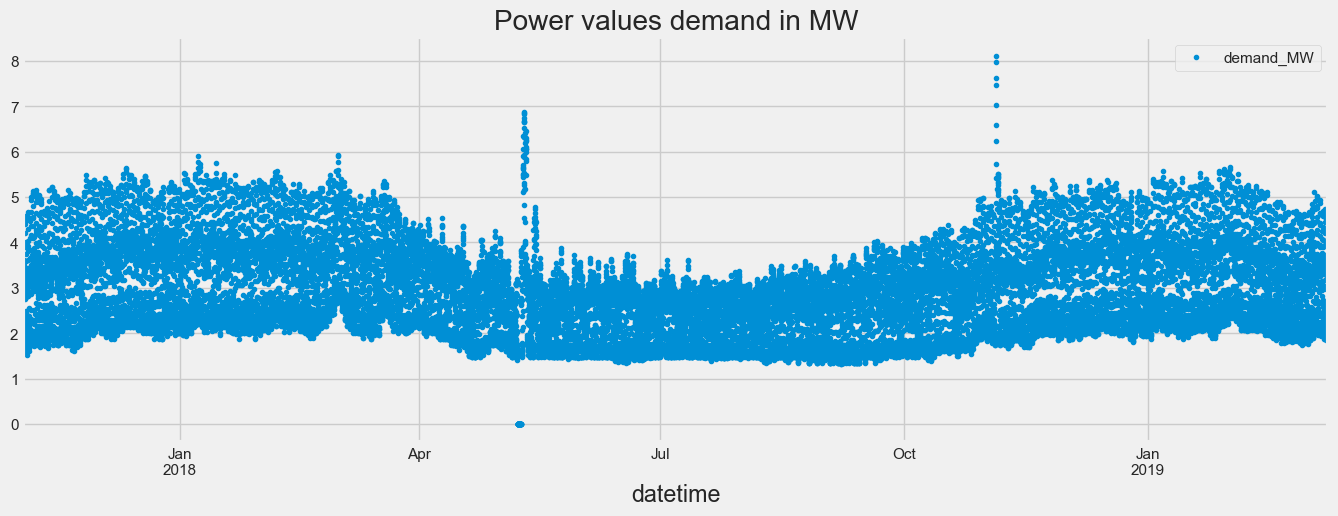

In [364]:
demand_data_dt.plot(style = '.', figsize = (15, 5), color = color_pal[0], title = 'Power values demand in MW')

In [365]:
# Define a function to plot different types of time-series

def plot_series(title = None, 
                end = None,
                start = 0,
                df = demand_data_dt, 
                column = 'demand_MW', 
                series = pd.Series([], dtype = float),
                xlabel = 'time',
                ylabel = 'demand in MW'):
    """
    Plots a certain time series. 
    The user can define the 'title', the 'start', and the 'end' of the plot.
    """
    sns.set()
    fig, ax = plt.subplots(figsize = (30, 15))
    ax.set_xlabel('Time', fontsize = 16)
    if column:
        ax.plot(df[column][start:end], label = xlabel)
        ax.set_ylabel(ylabel, fontsize = 16)
    if series.any():
        ax.plot(series, label = xlabel)
        ax.set_ylabel(ylabel, fontsize = 16)
    if xlabel:
        ax.legend(fontsize = 16)
    if title:
        ax.set_title(title, fontsize = 24)
    ax.grid(True)
    
    return ax

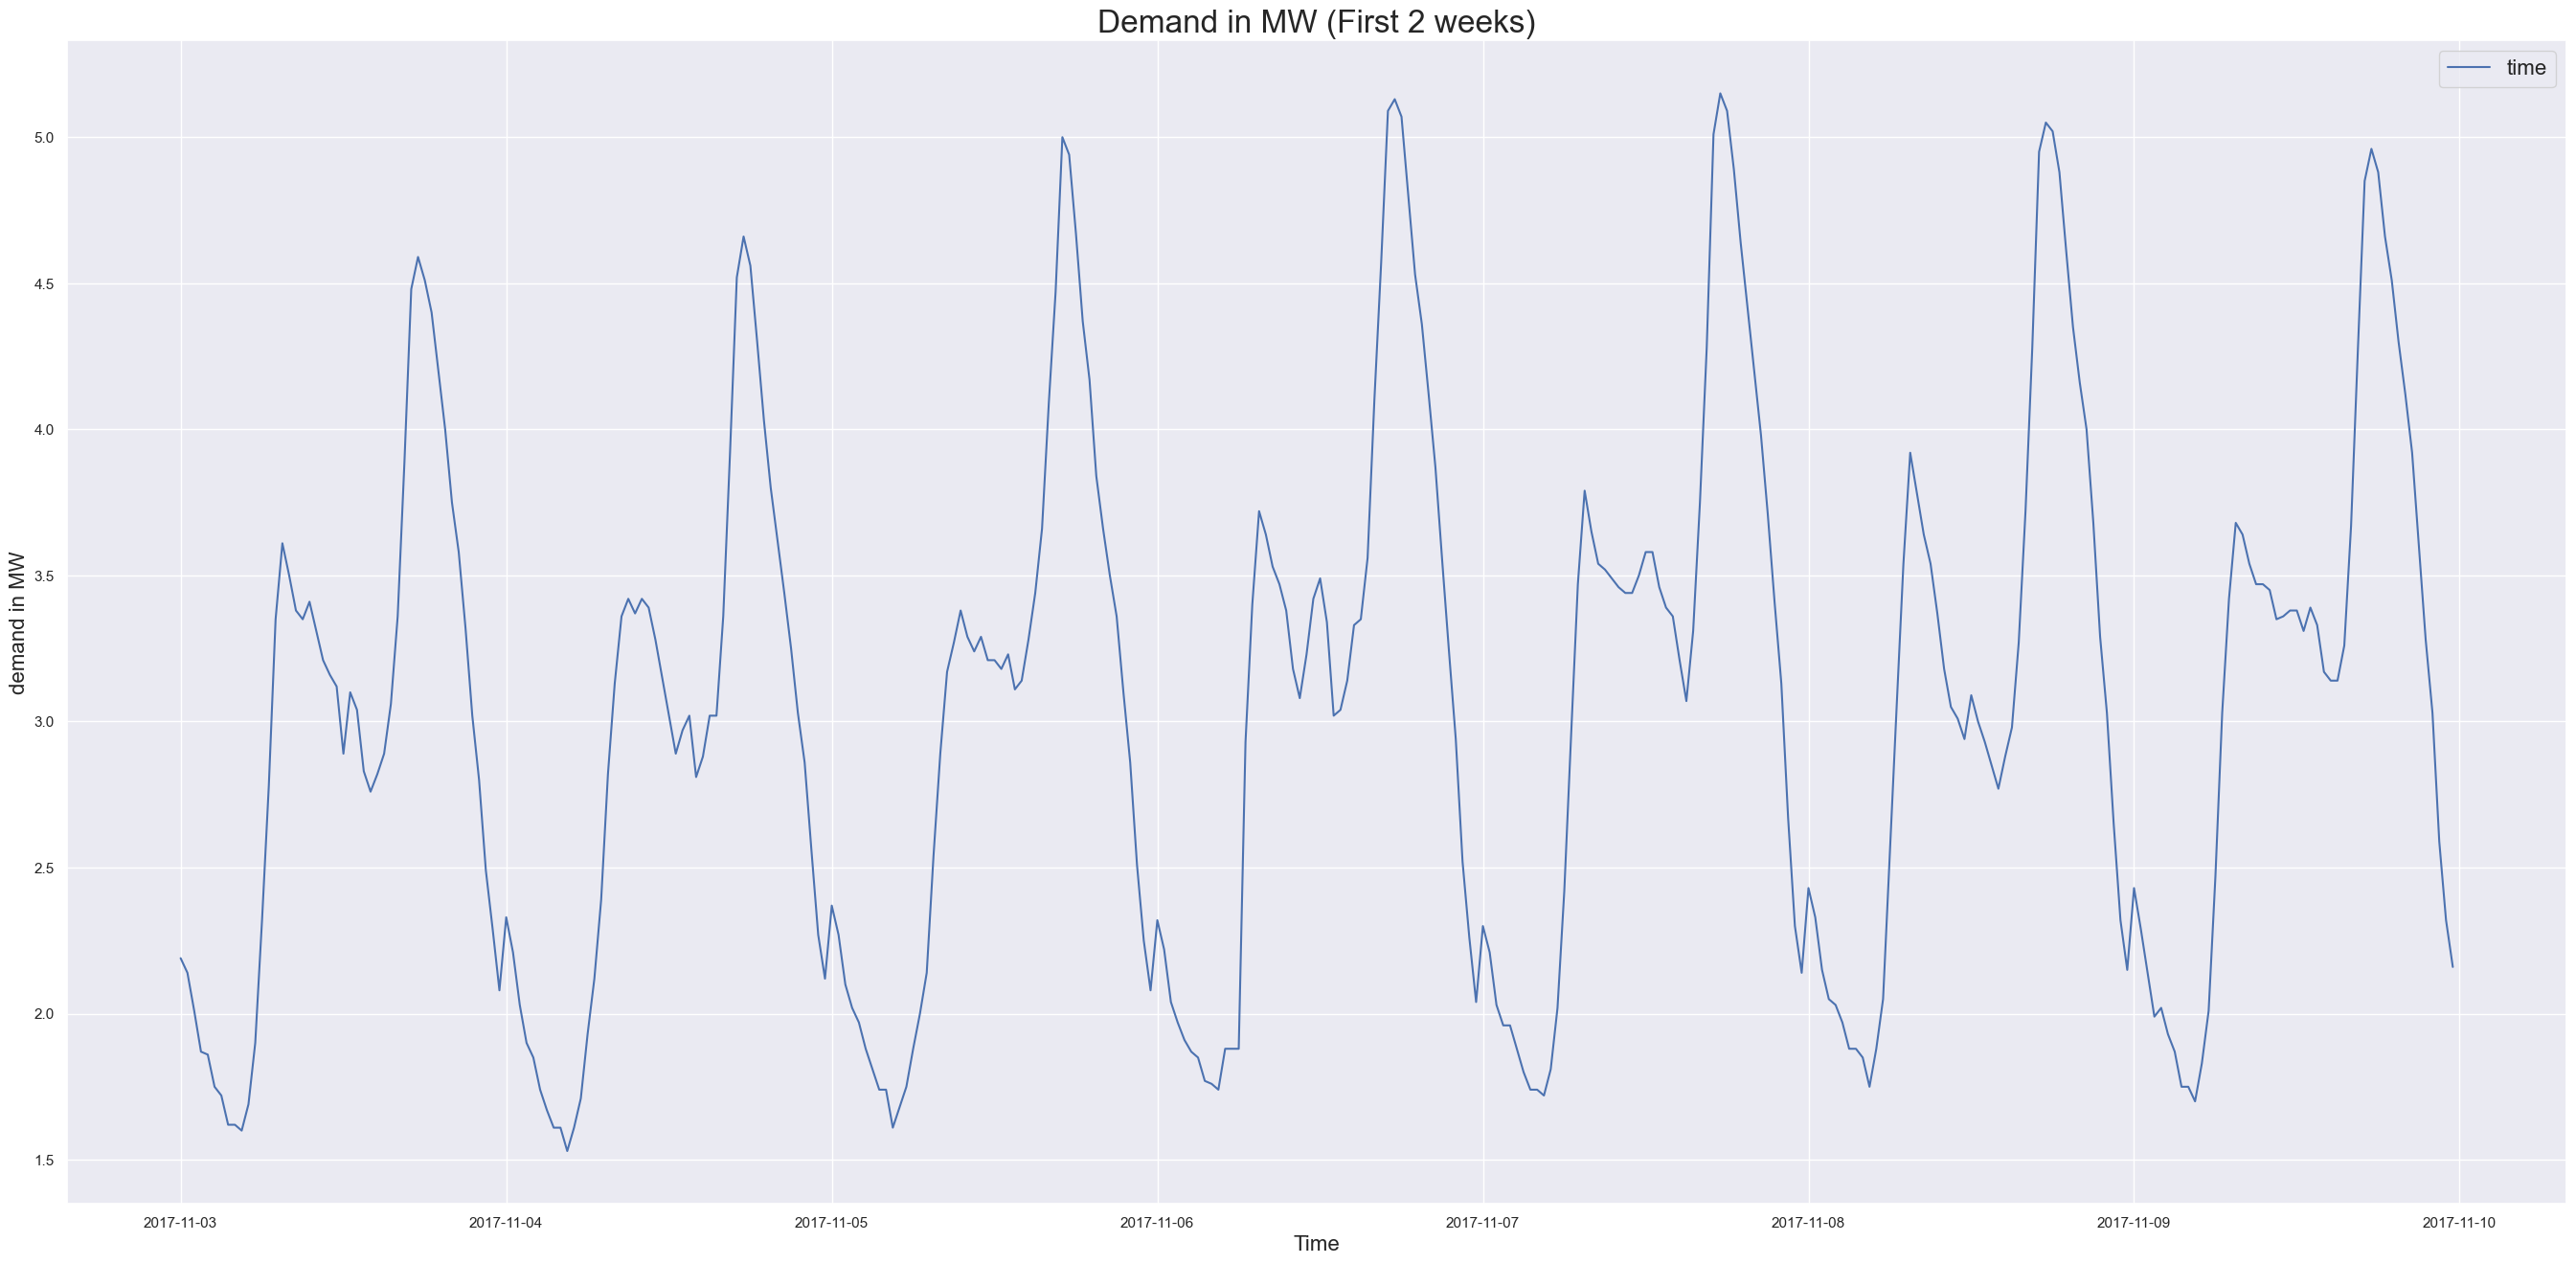

In [366]:
ax = plot_series(title = 'Demand in MW (First 2 weeks)', end = 24 * 7 * 2)
plt.show()

In [367]:
# Display the rows with null values

demand_data[demand_data.isnull().any(axis = 1)].tail()

,datetime,demand_MW


In [368]:
demand_data = demand_data.assign(datetime_dt = pd.to_datetime(demand_data['datetime']))

## Weather exploration

In [369]:
# Load demand data
weather_data = pd.read_csv('weather_set.csv')

# Find NaNs and duplicates

print('There are {} missing values or NaNs in weather_data.'
      .format(weather_data.isnull().values.sum()))

temp_weather = weather_data.duplicated(keep = 'first').sum()

print('There are {} duplicate rows in weather_data based on all columns.'
      .format(temp_weather))

# Reset index to datetime
# weather_data = weather_data.set_index('datetime')

weather_data.head()

There are 2232 missing values or NaNs in weather_data.
There are 167 duplicate rows in weather_data based on all columns.


,datetime,temp_location3,temp_location6,temp_location2,temp_location4,temp_location5,temp_location1,solar_location3,solar_location6,solar_location2,solar_location4,solar_location5,solar_location1
0,01-01-15 0:00,8.83,11.22,9.65,7.58,11.62,9.75,0.0,0.0,0.0,0.0,0.0,0.0
1,01-01-15 1:00,8.90,11.32,9.76,7.62,11.65,9.91,0.0,0.0,0.0,0.0,0.0,0.0
2,01-01-15 2:00,9.10,11.30,9.80,7.61,11.65,9.99,0.0,0.0,0.0,0.0,0.0,0.0
3,01-01-15 3:00,9.35,11.25,10.02,8.11,11.70,10.17,0.0,0.0,0.0,0.0,0.0,0.0
4,01-01-15 4:00,9.52,11.32,10.13,8.57,11.79,10.40,0.0,0.0,0.0,0.0,0.0,0.0


In [370]:
weather_data.interpolate(method = 'linear', limit_direction = 'forward', inplace = True, axis = 0)

In [371]:
# Print the type of each variable in weather_data
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36864 entries, 0 to 36863
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   datetime         36696 non-null  object 
 1   temp_location3   36864 non-null  float64
 2   temp_location6   36864 non-null  float64
 3   temp_location2   36864 non-null  float64
 4   temp_location4   36864 non-null  float64
 5   temp_location5   36864 non-null  float64
 6   temp_location1   36864 non-null  float64
 7   solar_location3  36864 non-null  float64
 8   solar_location6  36864 non-null  float64
 9   solar_location2  36864 non-null  float64
 10  solar_location4  36864 non-null  float64
 11  solar_location5  36864 non-null  float64
 12  solar_location1  36864 non-null  float64
dtypes: float64(12), object(1)
memory usage: 3.7+ MB


In [372]:
# Check distribution of missing values in each column
weather_data_cln = weather_data.dropna()
print("\nMissing Values Summary:")
print(weather_data_cln.isnull().sum())


Missing Values Summary:
datetime           0
temp_location3     0
temp_location6     0
temp_location2     0
temp_location4     0
temp_location5     0
temp_location1     0
solar_location3    0
solar_location6    0
solar_location2    0
solar_location4    0
solar_location5    0
solar_location1    0
dtype: int64


In [373]:
weather_data_cln.describe().round(2)

,temp_location3,temp_location6,temp_location2,temp_location4,temp_location5,temp_location1,solar_location3,solar_location6,solar_location2,solar_location4,solar_location5,solar_location1
count,36696.00,36696.00,36696.00,36696.00,36696.00,36696.00,36696.00,36696.00,36696.00,36696.00,36696.00,36696.00
mean,10.23,12.25,10.90,10.19,12.34,10.83,140.34,146.95,144.89,141.11,146.37,142.90
std,4.96,3.38,4.56,5.85,3.34,4.40,218.69,225.52,222.75,218.91,225.23,221.90
min,-5.80,1.17,-3.55,-6.28,1.11,-4.15,0.00,0.00,0.00,0.00,0.00,0.00
25%,6.60,9.70,7.56,5.91,9.83,7.62,0.00,0.00,0.00,0.00,0.00,0.00
50%,10.08,12.14,10.76,9.90,12.16,10.68,3.78,4.15,3.89,3.64,4.08,3.94
75%,13.82,15.05,14.21,14.29,15.06,14.07,214.00,229.00,223.94,216.19,226.11,216.56
max,26.19,22.95,25.93,29.39,22.71,25.45,937.25,940.50,938.00,929.25,941.25,941.50


### Notes
#### Temperatures are in Celsius. Maybe there might be a need to change that to Kelvin.
#### There are no longer missing values in temp_location4 and solar_location2.
#### It seems that there are no outliers, since the min and max values are close to each other, while the temperature values make sense.
#### The highest std can be found in the temp_location4, however, depending on the location, this could be a realistic case.

In [374]:
# Display basic statistics of the weather_data DataFrame
print("\nWeather Data Summary Statistics:")
print(weather_data_cln.describe())


Weather Data Summary Statistics:
       temp_location3  temp_location6  temp_location2  temp_location4  \
count    36696.000000    36696.000000    36696.000000    36696.000000   
mean        10.233373       12.253328       10.899438       10.187307   
std          4.962813        3.384443        4.563948        5.849314   
min         -5.800000        1.170000       -3.550000       -6.280000   
25%          6.600000        9.700000        7.560000        5.910000   
50%         10.080000       12.140000       10.760000        9.900000   
75%         13.820000       15.050000       14.210000       14.290000   
max         26.190000       22.950000       25.930000       29.390000   

       temp_location5  temp_location1  solar_location3  solar_location6  \
count    36696.000000    36696.000000     36696.000000     36696.000000   
mean        12.340836       10.825539       140.343217       146.951832   
std          3.344169        4.395082       218.694422       225.520935   
min     

In [375]:
weather_data_cln.tail()

,datetime,temp_location3,temp_location6,temp_location2,temp_location4,temp_location5,temp_location1,solar_location3,solar_location6,solar_location2,solar_location4,solar_location5,solar_location1
36691,09-03-19 19:00,7.03,9.85,8.04,6.28,9.79,8.08,0.0,0.0,0.0,0.0,0.0,0.0
36692,09-03-19 20:00,6.87,9.67,7.92,5.87,9.49,7.97,0.0,0.0,0.0,0.0,0.0,0.0
36693,09-03-19 21:00,6.69,9.43,7.80,5.52,9.28,7.81,0.0,0.0,0.0,0.0,0.0,0.0
36694,09-03-19 22:00,6.79,9.34,7.93,5.41,9.39,7.79,0.0,0.0,0.0,0.0,0.0,0.0
36695,09-03-19 23:00,6.88,9.87,7.98,5.36,10.43,7.99,0.0,0.0,0.0,0.0,0.0,0.0


In [376]:
# Create separate dataframes for each location
loc1_data = weather_data_cln[['temp_location1', 'solar_location1']]
loc2_data = weather_data_cln[['temp_location2', 'solar_location2']]
loc3_data = weather_data_cln[['temp_location3', 'solar_location3']]
loc4_data = weather_data_cln[['temp_location4', 'solar_location4']]
loc5_data = weather_data_cln[['temp_location5', 'solar_location5']]
loc6_data = weather_data_cln[['temp_location6', 'solar_location6']]

In [377]:
loc1_data = loc1_data.assign(datetime_dt = pd.to_datetime(weather_data_cln['datetime']))

In [378]:
loc1_data.head()

,temp_location1,solar_location1,datetime_dt
0,9.75,0.0,2015-01-01 00:00:00
1,9.91,0.0,2015-01-01 01:00:00
2,9.99,0.0,2015-01-01 02:00:00
3,10.17,0.0,2015-01-01 03:00:00
4,10.40,0.0,2015-01-01 04:00:00


<Axes: title={'center': 'Temperature'}>

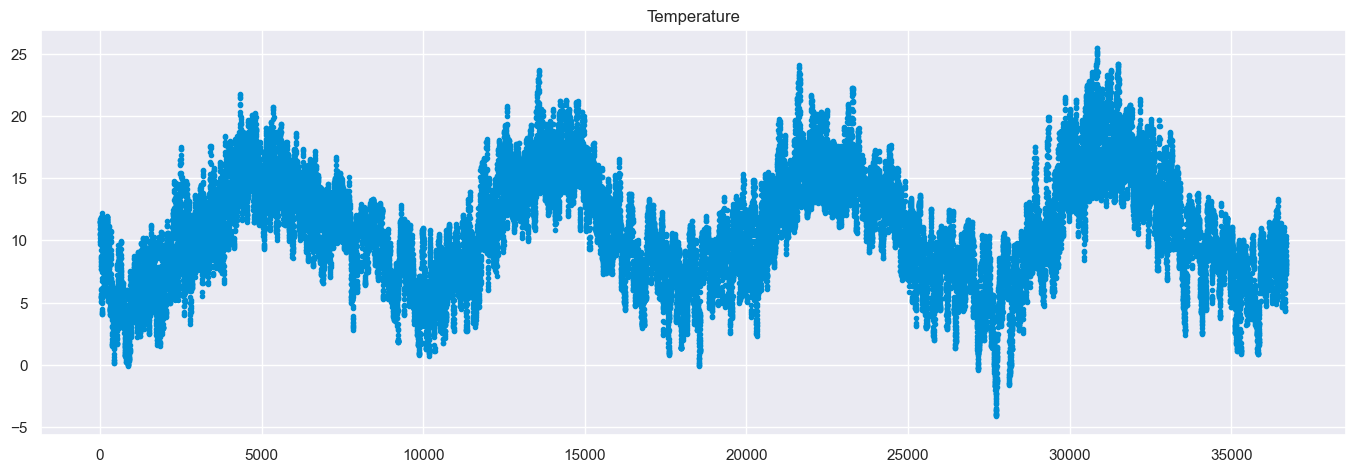

In [379]:
loc1_data['temp_location1'].plot(style = '.', figsize = (15, 5), color = color_pal[0], title = 'Temperature')

<Axes: title={'center': 'Irradiance'}>

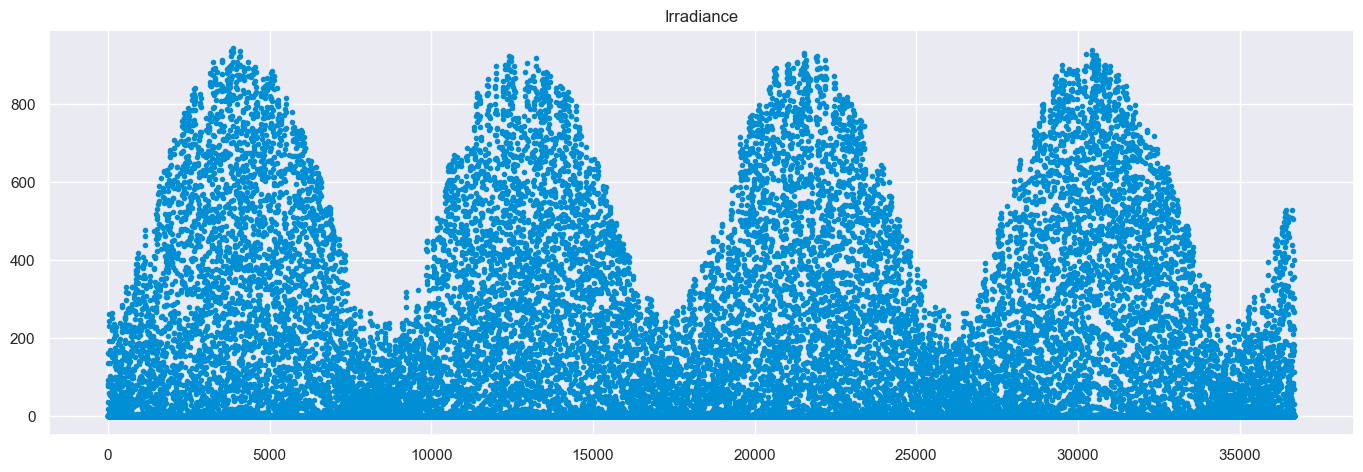

In [380]:
loc1_data['solar_location1'].plot(style = '.', figsize = (15, 5), color = color_pal[0], title = 'Irradiance')

In [381]:
# Display the number of rows in each dataframe

print('There are {} observations in demand_data.'.format(demand_data.shape[0]))

print('There are {} observations in loc1_data.'.format(loc1_data.shape[0]))

There are 23616 observations in demand_data.
There are 36696 observations in loc1_data.


In [382]:
loc1_data = loc1_data.assign(
    day_of_week = loc1_data['datetime_dt'].dt.dayofweek,
    hour_of_day = loc1_data['datetime_dt'].dt.hour,
    month = loc1_data['datetime_dt'].dt.month
)

In [383]:
loc1_data.tail()

,temp_location1,solar_location1,datetime_dt,day_of_week,hour_of_day,month
36691,8.08,0.0,2019-09-03 19:00:00,1,19,9
36692,7.97,0.0,2019-09-03 20:00:00,1,20,9
36693,7.81,0.0,2019-09-03 21:00:00,1,21,9
36694,7.79,0.0,2019-09-03 22:00:00,1,22,9
36695,7.99,0.0,2019-09-03 23:00:00,1,23,9


## Merge demand_data and dataframe of loc1

In [384]:
demand_data.head()

,datetime,demand_MW,datetime_dt
0,2017-11-03 00:00:00,2.19,2017-11-03 00:00:00
1,2017-11-03 00:30:00,2.14,2017-11-03 00:30:00
2,2017-11-03 01:00:00,2.01,2017-11-03 01:00:00
3,2017-11-03 01:30:00,1.87,2017-11-03 01:30:00
4,2017-11-03 02:00:00,1.86,2017-11-03 02:00:00


In [385]:
# Merge demand data and weather data based on matching datetime
merged_data = pd.merge(demand_data, loc1_data, on = 'datetime_dt', how = 'inner')

In [386]:
merged_data.tail(20)

,datetime,demand_MW,datetime_dt,temp_location1,solar_location1,day_of_week,hour_of_day,month
11212,2019-03-03 04:00:00,1.86,2019-03-03 04:00:00,8.23,0.00,6,4,3
11213,2019-03-03 05:00:00,1.85,2019-03-03 05:00:00,8.38,0.00,6,5,3
11214,2019-03-03 06:00:00,2.07,2019-03-03 06:00:00,8.84,0.05,6,6,3
11215,2019-03-03 07:00:00,2.33,2019-03-03 07:00:00,9.60,10.45,6,7,3
11216,2019-03-03 08:00:00,2.94,2019-03-03 08:00:00,10.48,42.55,6,8,3
11217,2019-03-03 09:00:00,3.63,2019-03-03 09:00:00,10.76,73.41,6,9,3
11218,2019-03-03 10:00:00,3.87,2019-03-03 10:00:00,10.78,55.81,6,10,3
11219,2019-03-03 11:00:00,3.97,2019-03-03 11:00:00,10.62,97.75,6,11,3
11220,2019-03-03 12:00:00,4.20,2019-03-03 12:00:00,10.51,142.50,6,12,3
11221,2019-03-03 13:00:00,4.12,2019-03-03 13:00:00,10.57,102.56,6,13,3


In [387]:
# Use Kelvin instead of Celsius
merged_data['temp_location1'] = merged_data['temp_location1'] + 273.15

In [388]:
column_to_drop = 'datetime_dt'
data = merged_data.drop(column_to_drop, axis = 1)
data.head()

,datetime,demand_MW,temp_location1,solar_location1,day_of_week,hour_of_day,month
0,2017-11-03 00:00:00,2.19,281.90,0.0,4,0,11
1,2017-11-03 01:00:00,2.01,281.95,0.0,4,1,11
2,2017-11-03 02:00:00,1.86,281.90,0.0,4,2,11
3,2017-11-03 03:00:00,1.72,281.85,0.0,4,3,11
4,2017-11-03 04:00:00,1.62,281.90,0.0,4,4,11


In [389]:
data.index = pd.to_datetime(data['datetime'])
column_to_drop = 'datetime'
data = data.drop(column_to_drop, axis = 1)
data.head()

,demand_MW,temp_location1,solar_location1,day_of_week,hour_of_day,month
datetime,,,,,,
2017-11-03 00:00:00,2.19,281.90,0.0,4,0,11
2017-11-03 01:00:00,2.01,281.95,0.0,4,1,11
2017-11-03 02:00:00,1.86,281.90,0.0,4,2,11
2017-11-03 03:00:00,1.72,281.85,0.0,4,3,11
2017-11-03 04:00:00,1.62,281.90,0.0,4,4,11


## Training

In [390]:
date = '01-01-2019'
train = data.loc[data.index < date]
test = data.loc[data.index >= date]

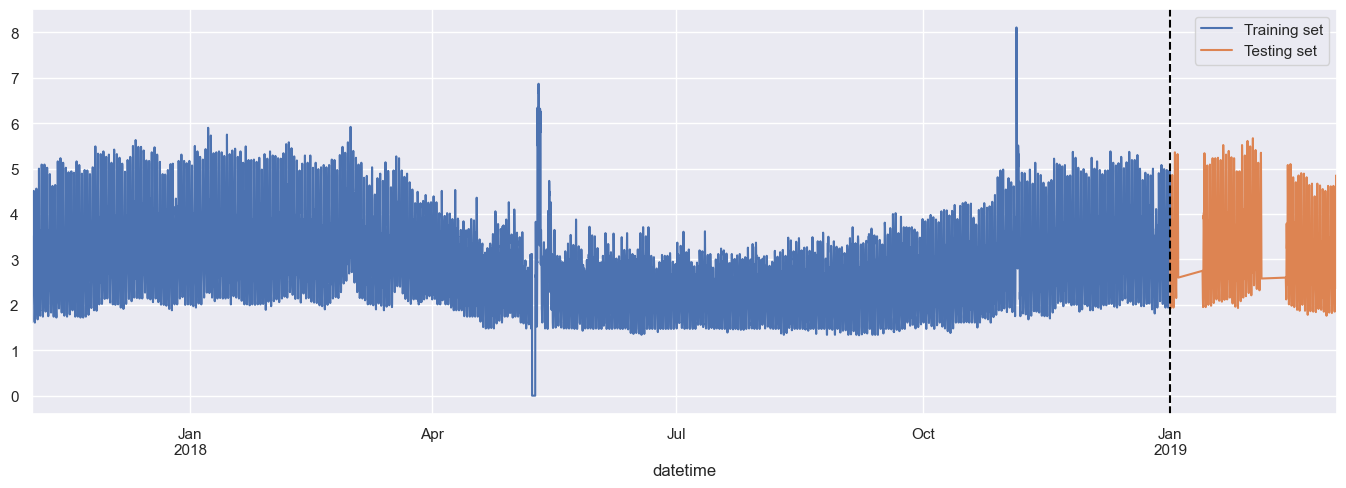

In [391]:
fig, ax = plt.subplots(figsize = (15, 5))
train['demand_MW'].plot(ax = ax, label = 'Train set')
test['demand_MW'].plot(ax = ax, label = 'Test set')
ax.axvline(date, color = 'black', ls = '--')
ax.legend(['Training set', 'Testing set'])
plt.show()

## Notes
* The demand drops during the summer months, as it was expected.
* There are some outliers that need to be treated.
* There are some gaps in the graph, this should be due to the drops from the datetime column. Most probably won't affect the results.

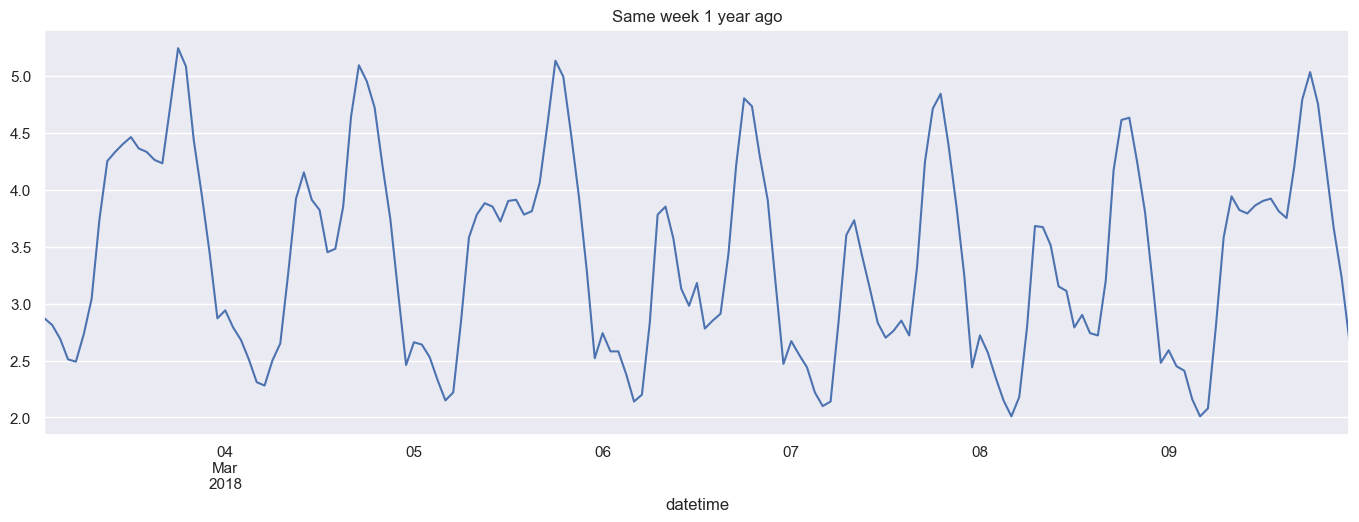

In [392]:
data['demand_MW'].loc[(data.index > '03-03-2018') & (data.index < '03-10-2018')].plot(figsize = (15, 5), title = "Same week 1 year ago")
plt.show()

## Feature Creation

#### Visualize Feature/Target relationship

In [393]:
data.columns

Index(['demand_MW', 'temp_location1', 'solar_location1', 'day_of_week',
       'hour_of_day', 'month'],
      dtype='object')

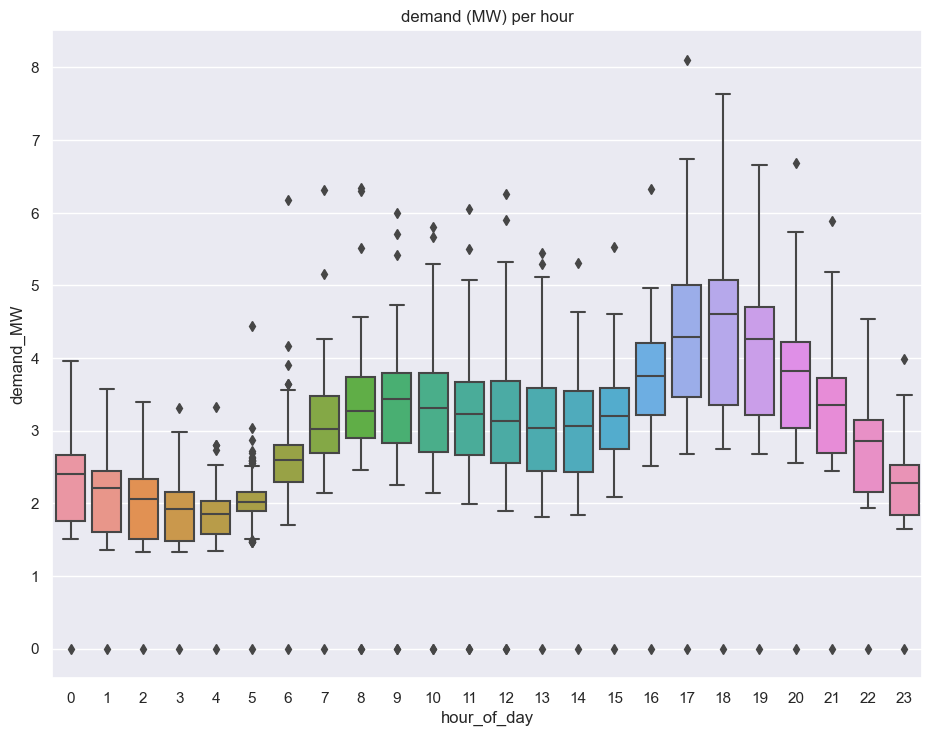

In [394]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.boxplot(data = data, x = 'hour_of_day', y = 'demand_MW')
ax.set_title('demand (MW) per hour')
plt.show()

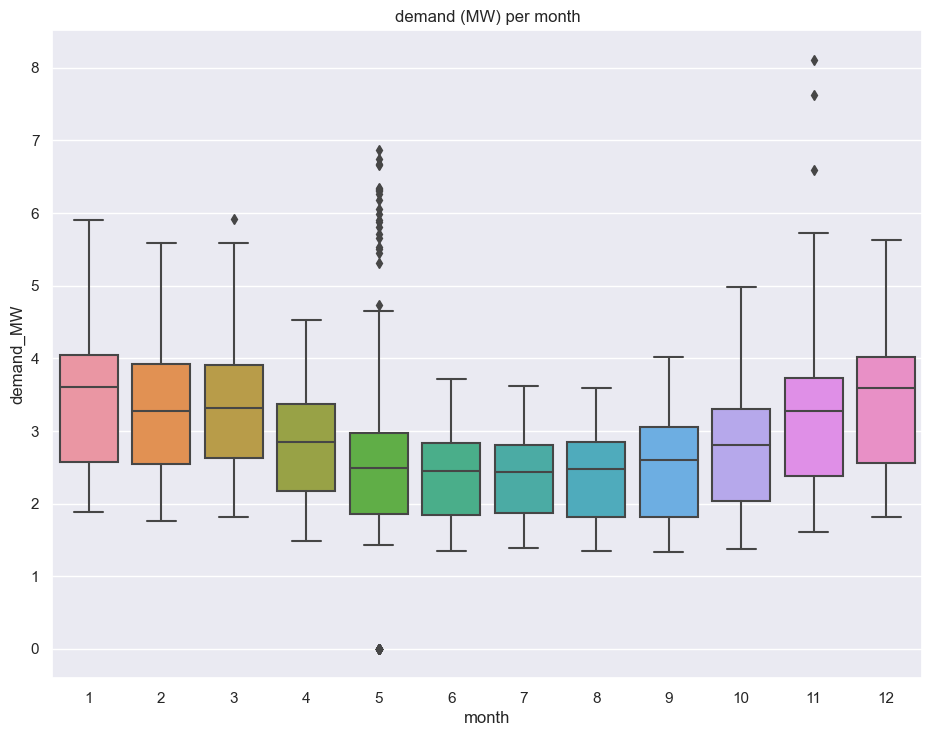

In [395]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.boxplot(data = data, x = 'month', y = 'demand_MW')
ax.set_title('demand (MW) per month')
plt.show()

In [396]:
# import packages
import xgboost as xgb
from sklearn.metrics import mean_squared_error

## Model

In [397]:
FEATURES = ['temp_location1', 'solar_location1', 'day_of_week', 'hour_of_day', 'month']
TARGET = 'demand_MW'

In [398]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [399]:
reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_roungs = 50, learning_rate = 0.005)
reg.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)],
        verbose = 50)

[19:22:04] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "early_stopping_roungs" } are not used.

[0]	validation_0-rmse:2.59814	validation_1-rmse:2.90523
[50]	validation_0-rmse:2.04030	validation_1-rmse:2.23711
[100]	validation_0-rmse:1.60873	validation_1-rmse:1.72297
[150]	validation_0-rmse:1.27471	validation_1-rmse:1.32760
[200]	validation_0-rmse:1.01784	validation_1-rmse:1.02552
[250]	validation_0-rmse:0.82257	validation_1-rmse:0.79951
[300]	validation_0-rmse:0.67554	validation_1-rmse:0.63302
[350]	validation_0-rmse:0.56659	validation_1-rmse:0.51440
[400]	validation_0-rmse:0.48715	validation_1-rmse:0.43297
[450]	validation_0-rmse:0.42947	validation_1-rmse:0.37868
[500]	validation_0-rmse:0.38877	validation_1-rmse:0.34761
[550]	validation_0-rmse:0.36064	validation_1-rmse:0.33190
[600]	validation_0-rmse:0.34088	validation_1-rmse:0.32579
[650]	validation_0-rmse:0.32616	validation_1-rmse:

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             early_stopping_roungs=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

## Feature Importance

In [400]:
fi = pd.DataFrame(data = reg.feature_importances_,
             index = reg.feature_names_in_,
             columns = ['importance'])

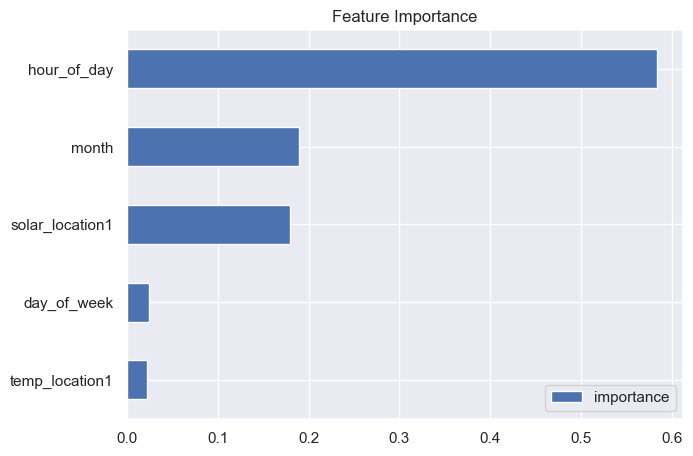

In [401]:
fi.sort_values('importance').plot(kind = 'barh', title = 'Feature Importance')
plt.show()

## Forecasting

In [402]:
reg.predict(X_test)

array([2.589307 , 2.434737 , 2.3418155, ..., 3.606624 , 3.0220222,
       2.4738982], dtype=float32)

In [403]:
preds = test.copy()

In [404]:
preds['prediction'] = reg.predict(X_test)
df = data.copy()
df = df.merge(preds[['prediction']], how = 'left', left_index = True, right_index = True)

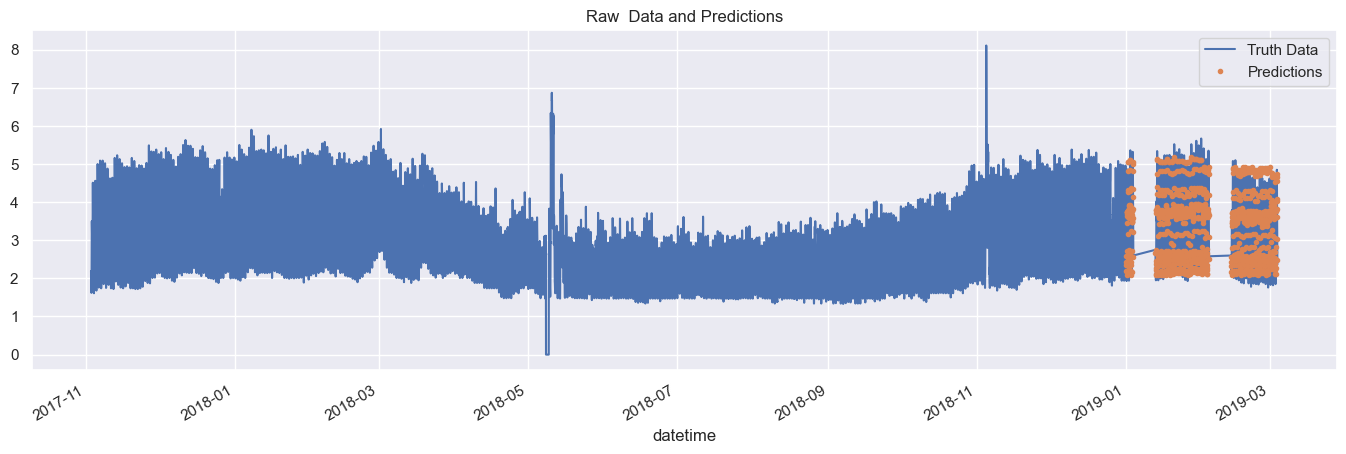

In [405]:
ax = df[['demand_MW']].plot(figsize = (15, 5))
df['prediction'].plot(ax = ax, style = '.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw  Data and Predictions')
plt.show()

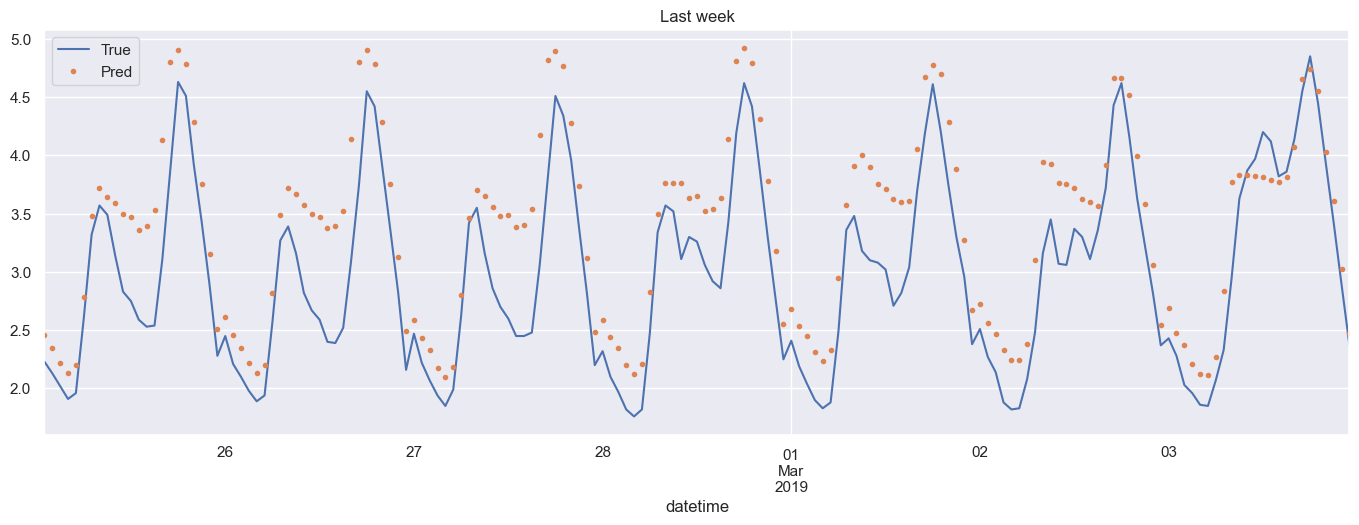

In [406]:
ax = df['demand_MW'].loc[(df.index > '02-25-2019') & (df.index < '03-04-2019')].plot(figsize = (15, 5), title = "Last week")
df['prediction'].loc[(df.index > '02-25-2019') & (df.index < '03-04-2019')].plot(style = '.')
plt.legend(['True', 'Pred'])
plt.show()

In [407]:
df.head()

,demand_MW,temp_location1,solar_location1,day_of_week,hour_of_day,month,prediction
datetime,,,,,,,
2017-11-03 00:00:00,2.19,281.90,0.0,4,0,11,NaN
2017-11-03 01:00:00,2.01,281.95,0.0,4,1,11,NaN
2017-11-03 02:00:00,1.86,281.90,0.0,4,2,11,NaN
2017-11-03 03:00:00,1.72,281.85,0.0,4,3,11,NaN
2017-11-03 04:00:00,1.62,281.90,0.0,4,4,11,NaN


## Retraining using all the data

In [408]:
X_all = data[FEATURES]
y_all = data[TARGET]

In [409]:
reg = xgb.XGBRegressor(n_estimators = 1000,
                       max_depth = 3,
                       learning_rate = 0.005)

reg.fit(X_all, y_all,
        eval_set = [(X_all, y_all)],
        verbose = 100)

[0]	validation_0-rmse:2.62900
[100]	validation_0-rmse:1.65695
[200]	validation_0-rmse:1.08506
[300]	validation_0-rmse:0.75822
[400]	validation_0-rmse:0.57232
[500]	validation_0-rmse:0.47696
[600]	validation_0-rmse:0.42855
[700]	validation_0-rmse:0.40224
[800]	validation_0-rmse:0.38568
[900]	validation_0-rmse:0.37518
[999]	validation_0-rmse:0.36768


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [410]:
data.index.max()

Timestamp('2019-03-03 23:00:00')

In [411]:
date_range = pd.date_range('2019-03-03', '2019-03-11', freq = '1h')

print(date_range)

DatetimeIndex(['2019-03-03 00:00:00', '2019-03-03 01:00:00',
               '2019-03-03 02:00:00', '2019-03-03 03:00:00',
               '2019-03-03 04:00:00', '2019-03-03 05:00:00',
               '2019-03-03 06:00:00', '2019-03-03 07:00:00',
               '2019-03-03 08:00:00', '2019-03-03 09:00:00',
               ...
               '2019-03-10 15:00:00', '2019-03-10 16:00:00',
               '2019-03-10 17:00:00', '2019-03-10 18:00:00',
               '2019-03-10 19:00:00', '2019-03-10 20:00:00',
               '2019-03-10 21:00:00', '2019-03-10 22:00:00',
               '2019-03-10 23:00:00', '2019-03-11 00:00:00'],
              dtype='datetime64[ns]', length=193, freq='H')


In [412]:
future_df = pd.DataFrame(index = date_range)
future_df['isFuture'] = True
future_df = future_df.assign(
    day_of_week = future_df.index.dayofweek,
    hour_of_day = future_df.index.hour,
    month = future_df.index.month
)
data['isFuture'] = False
conc = pd.concat([data, future_df])

In [413]:
conc.tail()

,demand_MW,temp_location1,solar_location1,day_of_week,hour_of_day,month,isFuture
2019-03-10 20:00:00,NaN,NaN,NaN,6,20,3,True
2019-03-10 21:00:00,NaN,NaN,NaN,6,21,3,True
2019-03-10 22:00:00,NaN,NaN,NaN,6,22,3,True
2019-03-10 23:00:00,NaN,NaN,NaN,6,23,3,True
2019-03-11 00:00:00,NaN,NaN,NaN,0,0,3,True


In [414]:
# Identify missing temperature values
missing_temp_indices = conc[conc['temp_location1'].isnull()].index
missing_solar_indices = conc[conc['solar_location1'].isnull()].index

# Fill missing temperature values with values from the same dates in the previous year
for idx in missing_temp_indices:
    date_to_fill = idx
    previous_year_date = date_to_fill - pd.DateOffset(years=1)
    
    previous_year_data = conc[conc.index.date == previous_year_date.date()]
    if not previous_year_data.empty:
        previous_year_temp = previous_year_data.iloc[0]['temp_location1']
        conc.at[idx, 'temp_location1'] = previous_year_temp

for idx in missing_solar_indices:
    date_to_fill = idx
    previous_year_date = date_to_fill - pd.DateOffset(years=1)
    
    previous_year_data = conc[conc.index.date == previous_year_date.date()]
    if not previous_year_data.empty:
        previous_year_solar = previous_year_data.iloc[0]['solar_location1']
        conc.at[idx, 'solar_location1'] = previous_year_solar

# Now merged_data contains missing temperature values filled with values from the same dates in the previous year
print(conc.tail())

                     demand_MW  temp_location1  solar_location1  day_of_week  \
2019-03-10 20:00:00        NaN           285.9              0.0            6   
2019-03-10 21:00:00        NaN           285.9              0.0            6   
2019-03-10 22:00:00        NaN           285.9              0.0            6   
2019-03-10 23:00:00        NaN           285.9              0.0            6   
2019-03-11 00:00:00        NaN           282.6              0.0            0   

                     hour_of_day  month  isFuture  
2019-03-10 20:00:00           20      3      True  
2019-03-10 21:00:00           21      3      True  
2019-03-10 22:00:00           22      3      True  
2019-03-10 23:00:00           23      3      True  
2019-03-11 00:00:00            0      3      True  


In [415]:
conc_future = conc.query('isFuture').copy()

conc_future['pred'] = reg.predict(conc_future[FEATURES])

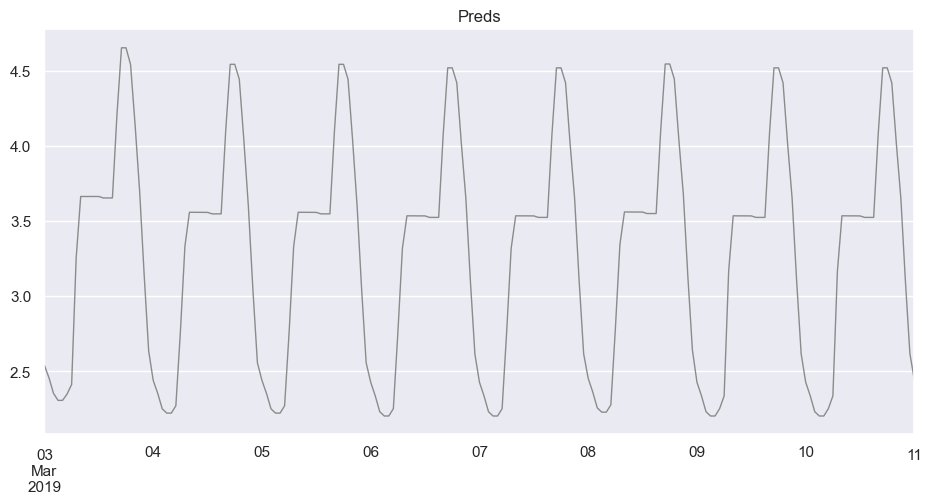

In [416]:
conc_future['pred'].plot(figsize = (10, 5),
                         color = color_pal[4],
                         ms = 1, 
                         lw = 1,
                         title = 'Preds')
plt.show()

In [417]:
conc_future.loc[conc_future.index > '2019-03-10']['pred']

2019-03-10 01:00:00    2.336420
2019-03-10 02:00:00    2.230559
2019-03-10 03:00:00    2.202097
2019-03-10 04:00:00    2.202097
2019-03-10 05:00:00    2.250848
2019-03-10 06:00:00    2.335253
2019-03-10 07:00:00    3.165742
2019-03-10 08:00:00    3.533664
2019-03-10 09:00:00    3.533664
2019-03-10 10:00:00    3.533664
2019-03-10 11:00:00    3.533664
2019-03-10 12:00:00    3.532946
2019-03-10 13:00:00    3.523120
2019-03-10 14:00:00    3.523120
2019-03-10 15:00:00    3.523120
2019-03-10 16:00:00    4.074965
2019-03-10 17:00:00    4.517827
2019-03-10 18:00:00    4.517827
2019-03-10 19:00:00    4.418535
2019-03-10 20:00:00    4.016870
2019-03-10 21:00:00    3.650762
2019-03-10 22:00:00    3.101663
2019-03-10 23:00:00    2.615494
2019-03-11 00:00:00    2.438972
Name: pred, dtype: float32

## Comments
In this approach, there are several steps that can be improved.

* Examine better ways to treat the missing values.
* Evaluate the interpolation methods and pick the one performing the best.
* Instead of dropping the missing values from the datetime, same methods should be followed, to avoid the gap in some dates.
* Instead of simplifying it to 1h step per day, the weather dataframe could be adapted to a 0.5h dataframe, and fit better to the requested question.
* Further evaluation on the importance of the features should be performed, to enhance the parameters used in the model.
* The outliers were just ignored here, however, there should be handled accordingly, maybe by replacing them with a mean value, or exploring more methods.
* Only xgb model was tried here, however, there are several options to be considered, depending on the complexity needed.
* Instead of replacing the missing weather values with the same as previous year, a more sophisticated method should be introduced to combine seasonality with trends on the current year.